In [64]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import mediapipe as mp

# Import Images

image: ../resources/images\squat-deep-yellow-negative.jpg


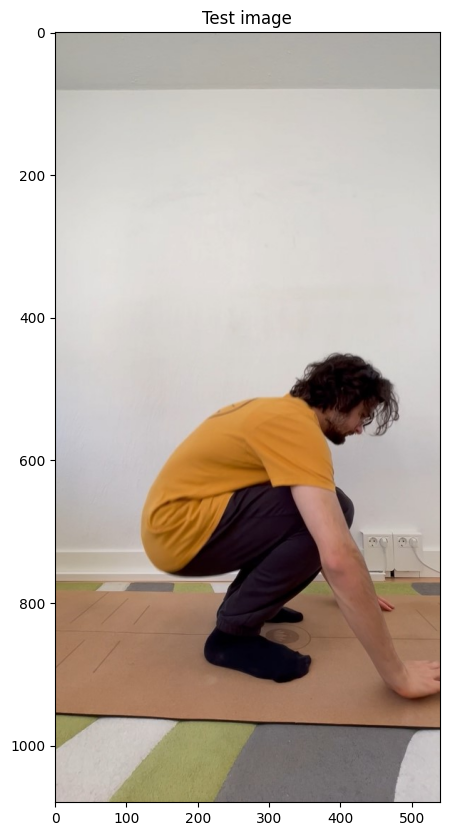

image: ../resources/images\squat-deep-yellow-positive.jpg


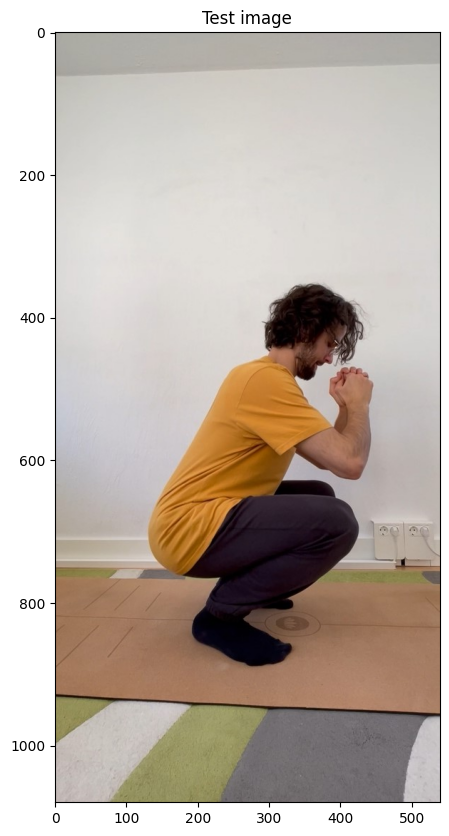

image: ../resources/images\squat-high-yellow-positive.jpg


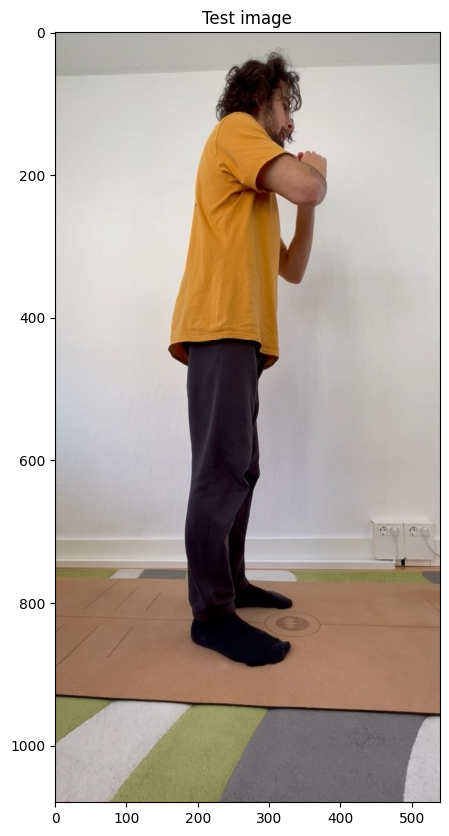

image: ../resources/images\squat-middle-yellow-negative.jpg


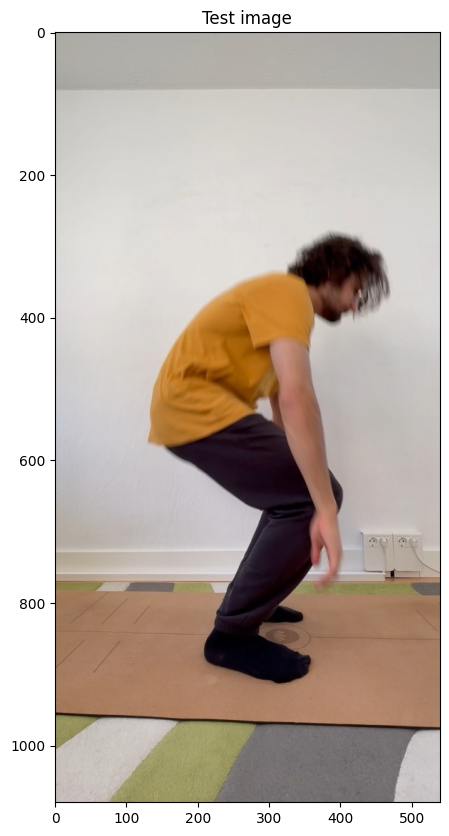

image: ../resources/images\squat-middle-yellow-positive.jpg


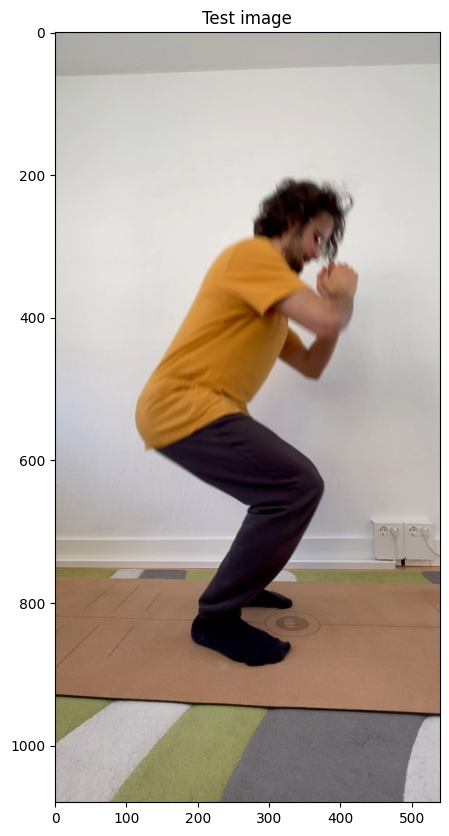

In [65]:
# Load test images
image_path = glob.glob('../resources/images/*yellow*.jpg')  # grab only images with yellow tshirt
images = []

for img in image_path:
    print("image: " + img)
    # Load the test image
    test_img = cv.imread(img)

    images.append(test_img)

    # Show Testimage
    plt.figure(figsize=(20, 10))
    plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
    plt.title('Test image')
    plt.show()

# ROI
 Assuming that the spine is always in the left side of the image, because the person is always right in front of the camera.



## Detect Key Points with HPE
PoC: Detecting spine with Mediapipe HPE

Important keypoints for spine detection are:
- 11 - left shoulder
- 12 - right shoulder
- 23 - left hip
- 24 - right hip

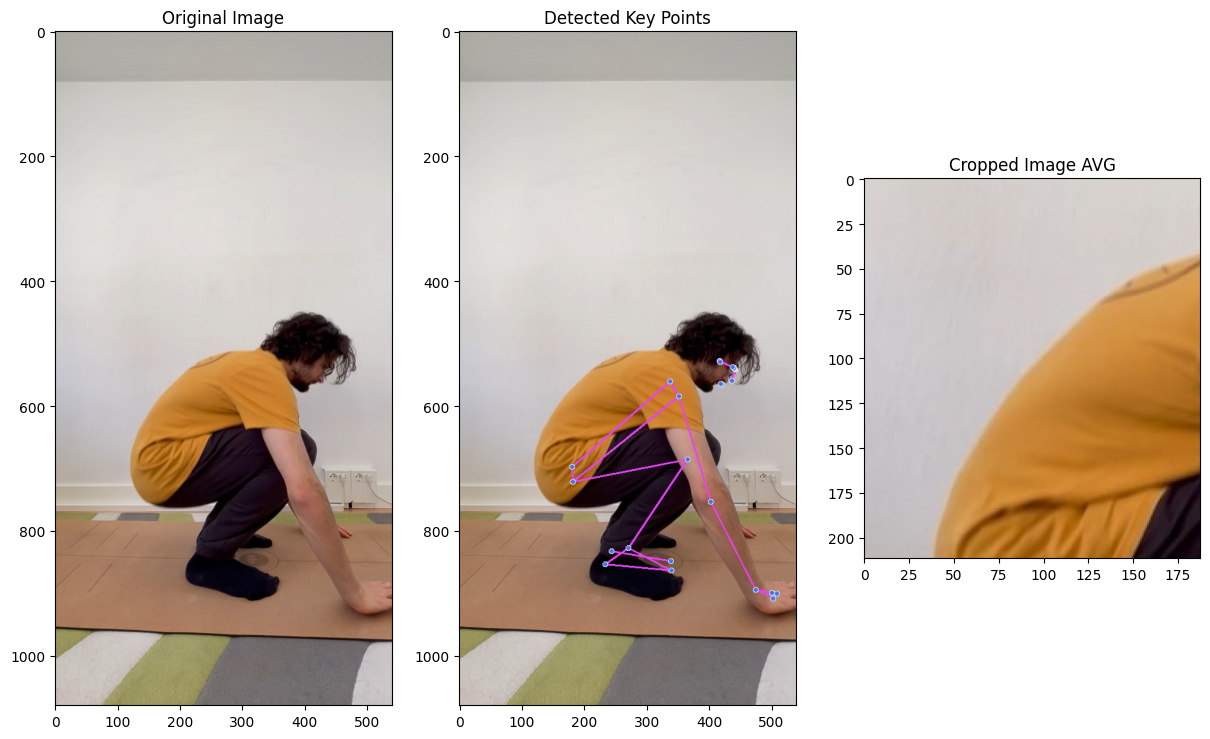

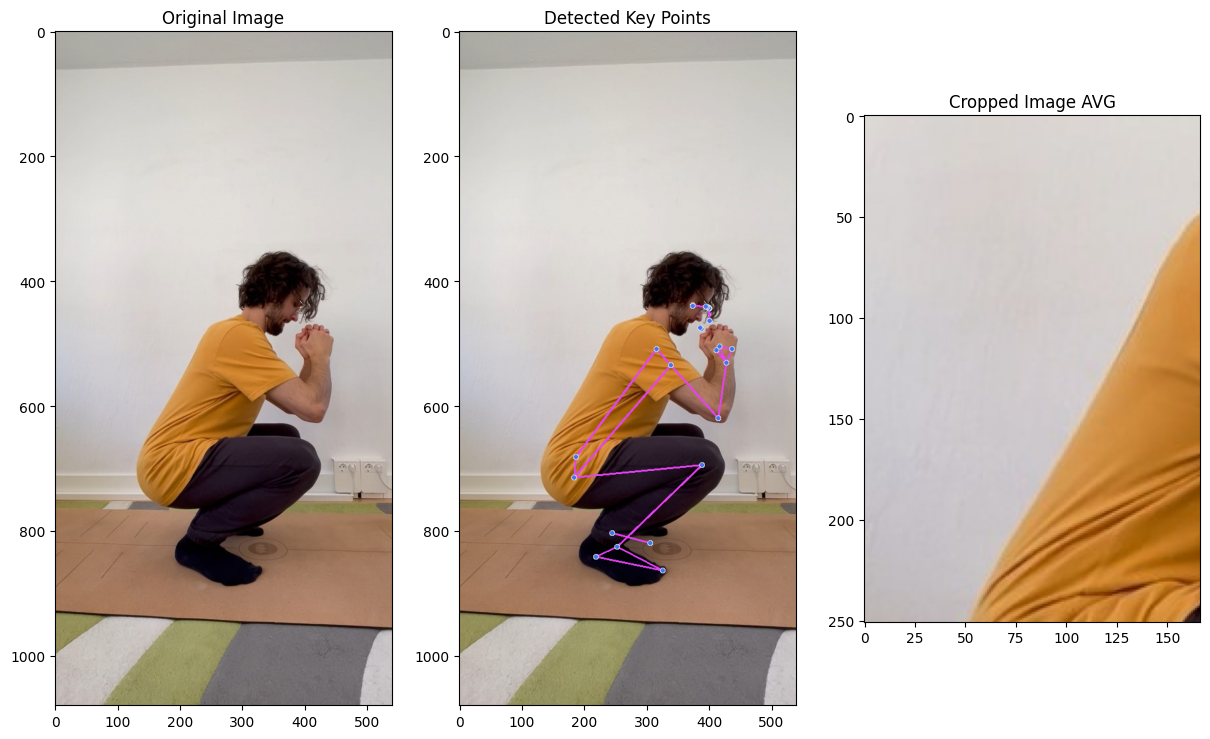

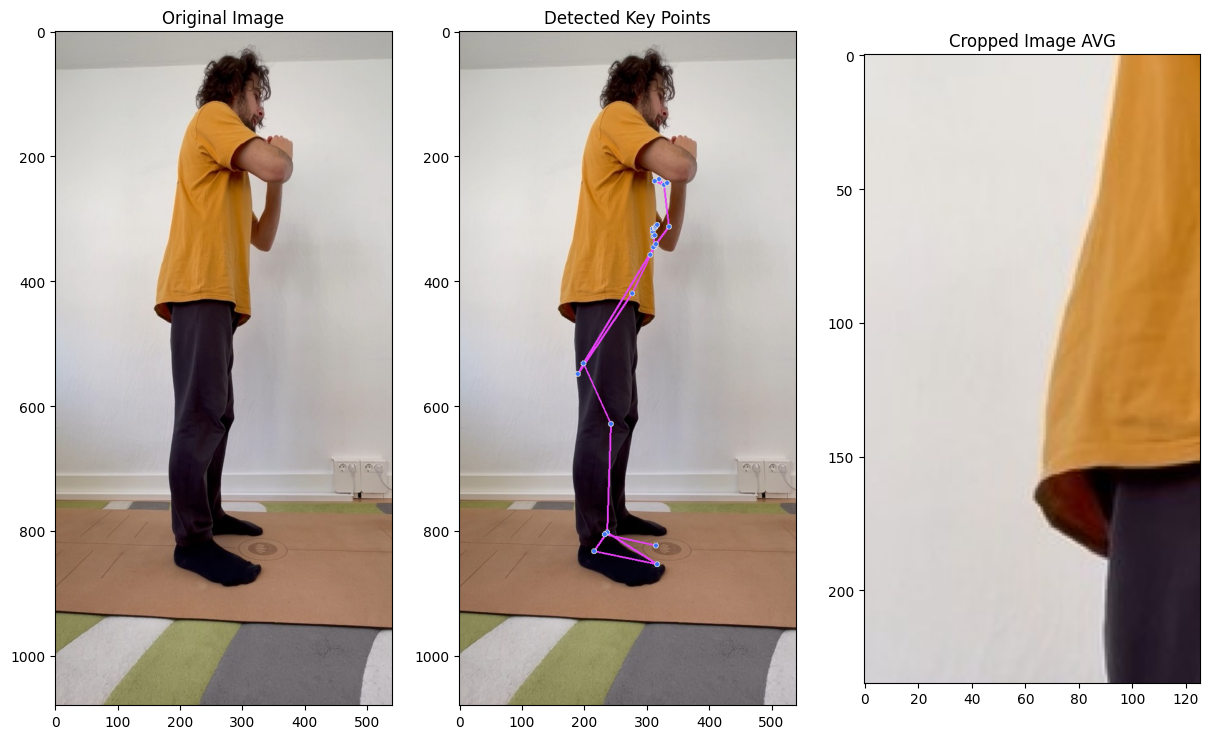

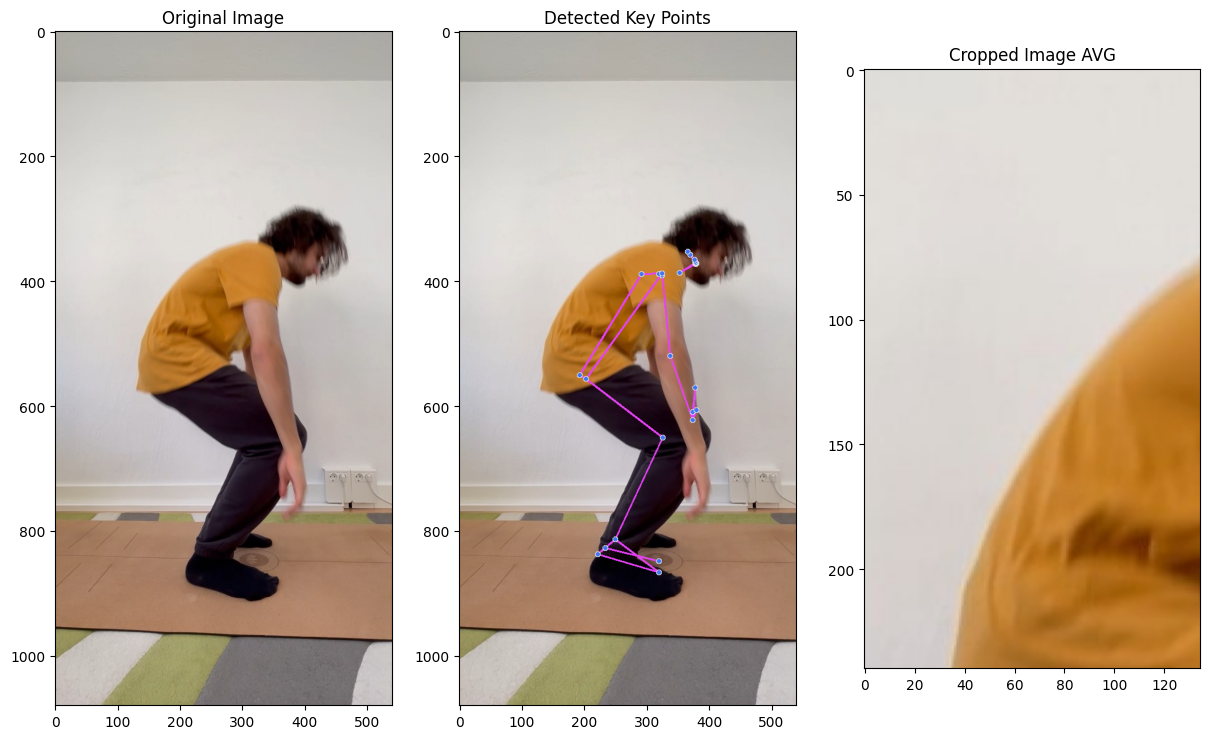

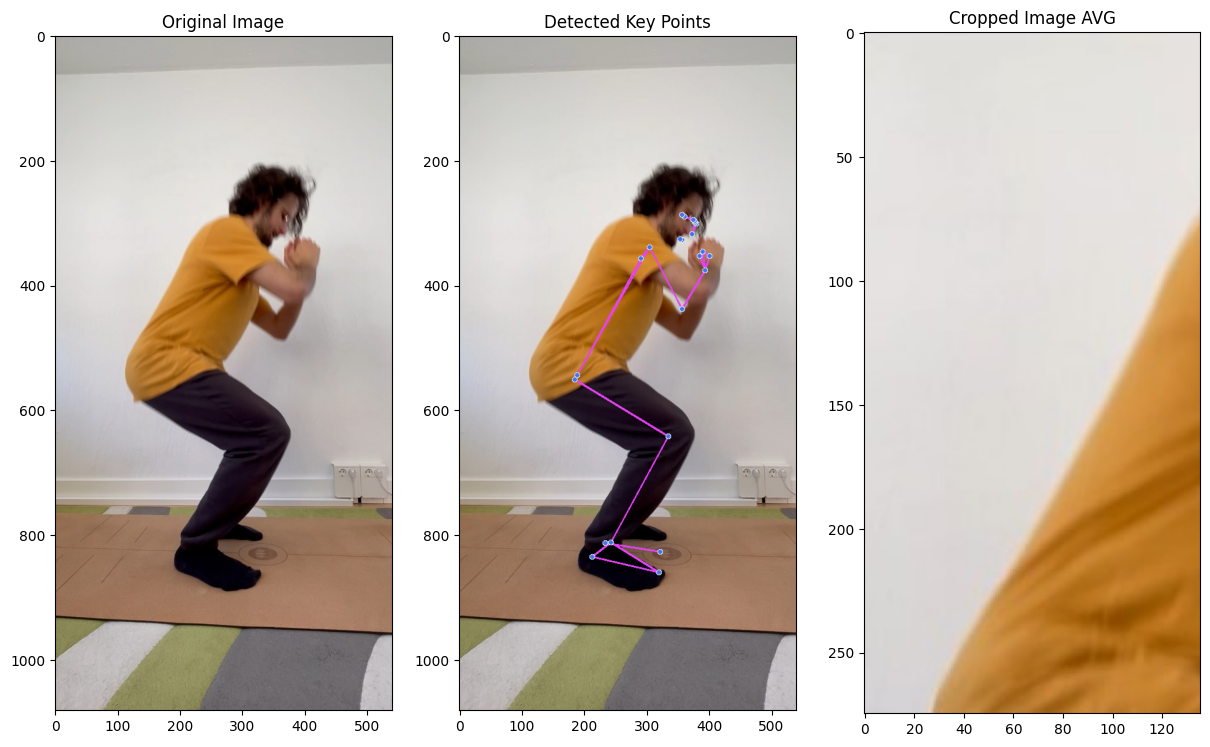

In [66]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cropped_images = []

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for img in images:
        # Recolor image to RGB
        # img_keypoints = img.copy()
        img_keypoints = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_keypoints.flags.writeable = False
        
        image_height, image_width, _ = img_keypoints.shape

        # Make detection
        results = pose.process(img_keypoints)

        # Recolor back to BGR
        img_keypoints.flags.writeable = True
        img_keypoints = cv.cvtColor(img_keypoints, cv.COLOR_RGB2BGR)

        # Render detections
        mp_drawing.draw_landmarks(img_keypoints, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                  )
        
      
        left_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width
        left_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
        
        right_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width
        right_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height
        
        left_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * image_width
        left_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * image_height
        
        right_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * image_width
        right_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * image_height
        
        avg_shoulder_x = (left_shoulder_x + right_shoulder_x) / 2
        avg_shoulder_y = (left_shoulder_y + right_shoulder_y) / 2
        
        avg_hip_x = (left_hip_x + right_hip_x) / 2
        avg_hip_y = (left_hip_y + right_hip_y) / 2
        
        # first test with only left key points
        # crop image
        # [y1:y2, x1:x2]
        cropped_img_left = img[int(left_shoulder_y):int(left_hip_y), int(left_hip_x):int(left_shoulder_x)]
        cropped_img_right = img[int(right_shoulder_y):int(right_hip_y), int(right_hip_x):int(right_shoulder_x)]
        
        # padding_top_left = 100
        # padding_bottom_right = -10
        # cropped_img_avg = img[int(avg_shoulder_y) - padding_top_left:int(avg_hip_y) + padding_bottom_right,
        #                   int(avg_hip_x) - padding_top_left:int(avg_shoulder_x) + padding_bottom_right]
    
        padding_top = 100
        padding_bottom = 25
        padding_left = 100
        padding_right = 75
        cropped_img_avg = img[int(avg_shoulder_y) - padding_top: int(avg_hip_y) - padding_bottom,
                          int(avg_hip_x) - padding_left: int(avg_shoulder_x) -  padding_right]
        
        cropped_images.append(cropped_img_avg)

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 4, 1)
        plt.title('Original Image')
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.subplot(1, 4, 2)
        plt.title('Detected Key Points')
        plt.imshow(cv.cvtColor(img_keypoints, cv.COLOR_BGR2RGB))
        plt.subplot(1, 4, 3)
        plt.title('Cropped Image AVG')
        plt.imshow(cv.cvtColor(cropped_img_avg, cv.COLOR_BGR2RGB))
        plt.show()


## Crop Image with static values

In [67]:
# cropped_images = []
# 
# for img in images:
#     # zuschneiden des Bildes
#     cropped_img = img[:, 50:300]
#     cropped_images.append(cropped_img)
# 
#     plt.figure(figsize=(20, 10))
#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#     plt.subplot(1, 2, 2)
#     plt.title('Cropped Image')
#     plt.imshow(cv.cvtColor(cropped_images[-1], cv.COLOR_BGR2RGB))
#     plt.show()


# Apply Color Filter 

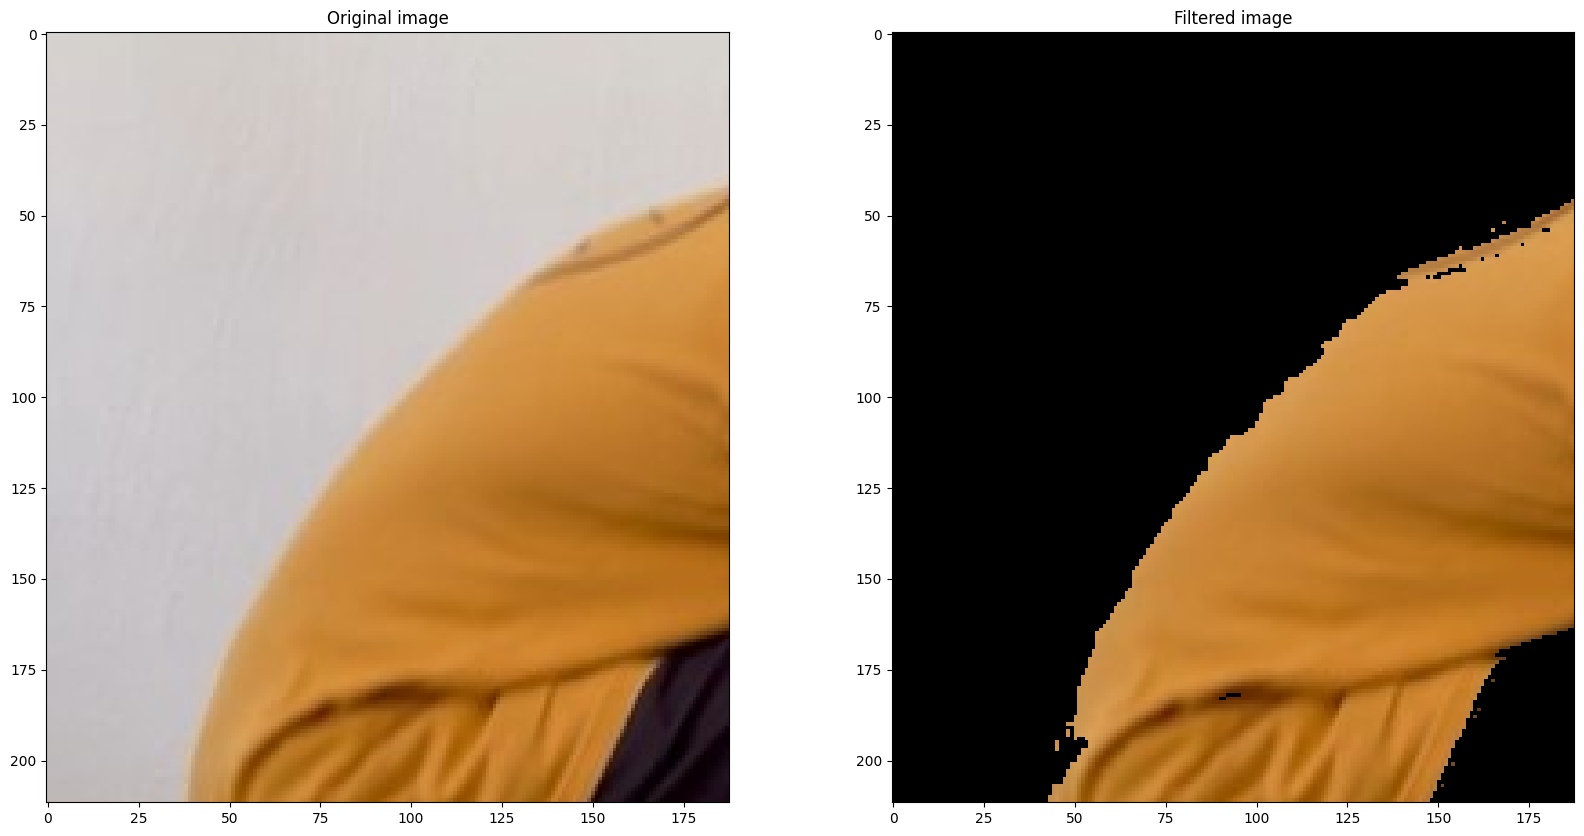

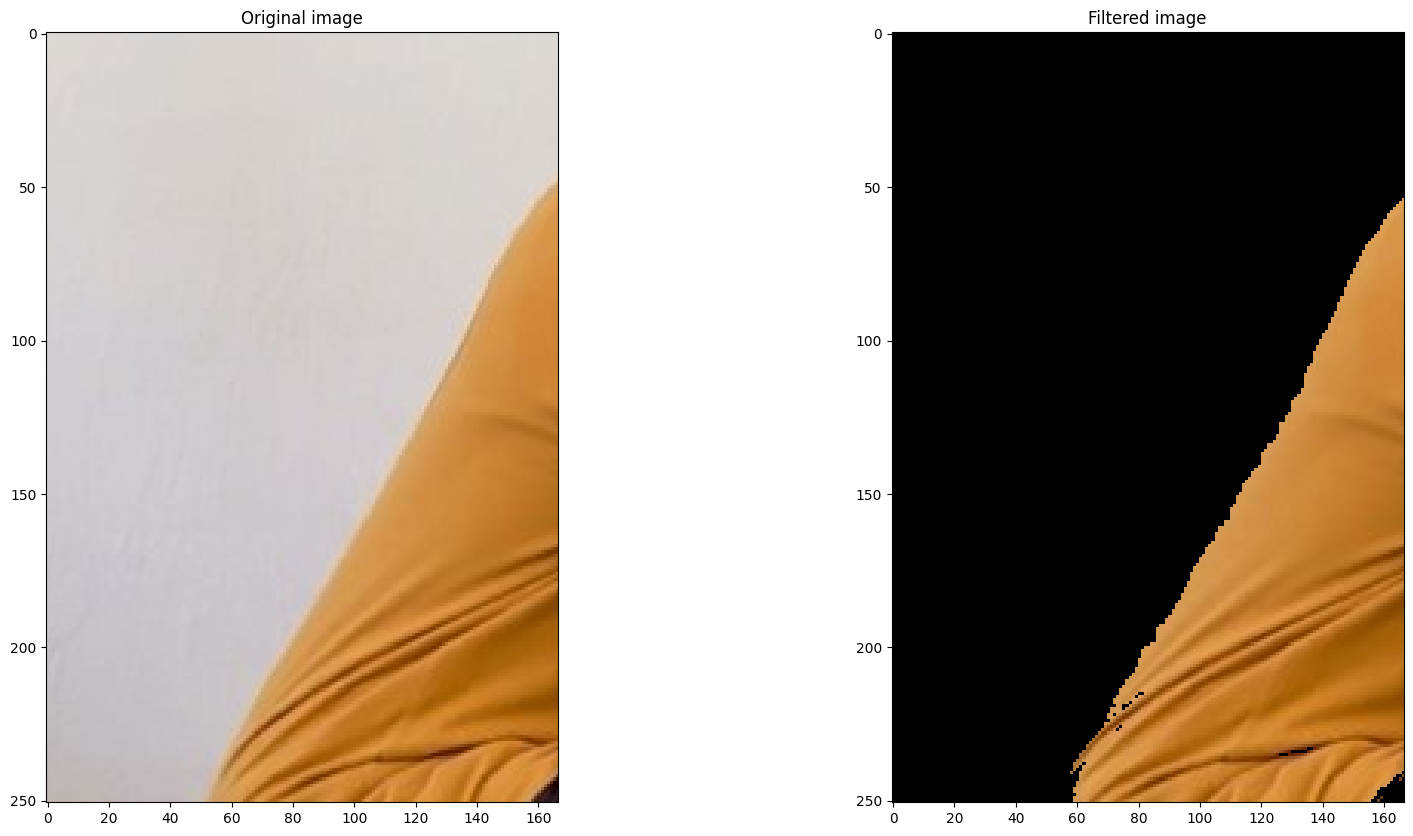

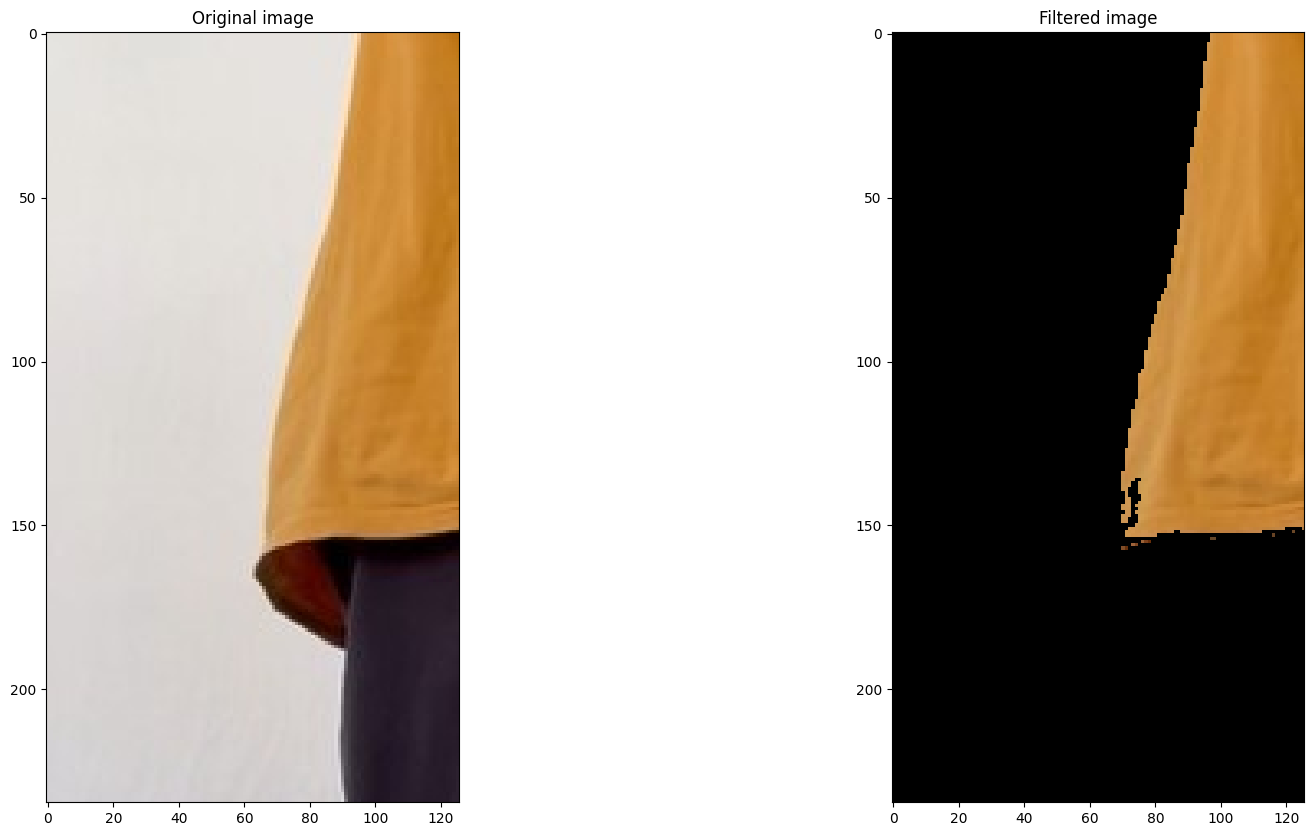

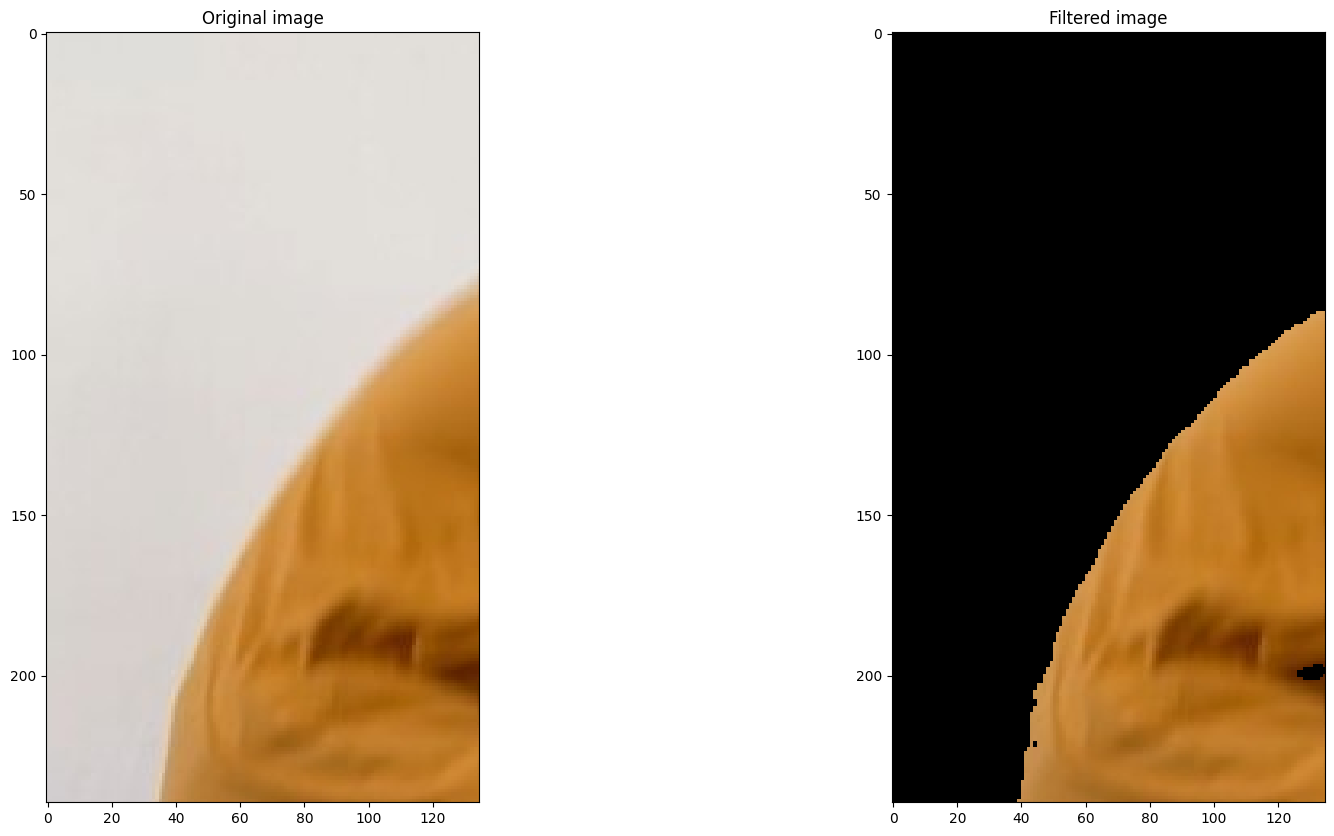

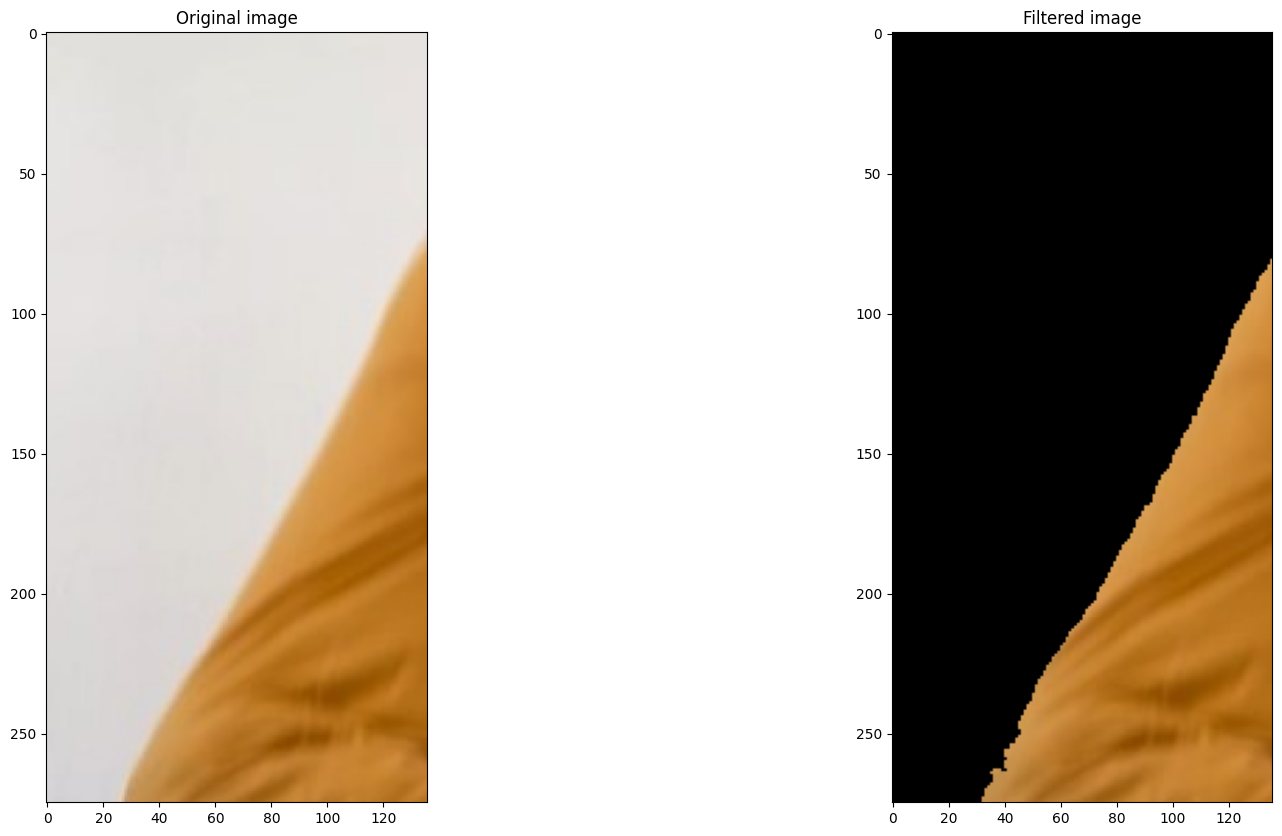

In [68]:
img_filtered = []

for img in cropped_images:
    # Convert BGR to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # define yellow color range in HSV
    lower_yellow = np.array([0, 150, 100])
    upper_yellow = np.array([30, 255, 255])
    img_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)

    # filter yellow areas
    img_filtered_yellow = img.copy()
    img_filtered_yellow[np.where(img_yellow == 0)] = 0

    img_filtered.append(img_filtered_yellow)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(img_filtered_yellow, cv.COLOR_BGR2RGB))
    plt.title('Filtered image')
    plt.show()

# Spine Detection with Contour Detection
Detecting spine with contour detection:

1) Convert image to grayscale
2) Apply Gaussian Blur
3) Apply Canny Edge Detection
4) Extract contours
5) sort contours by sum of x and y coordinate (Assumption: Spine is the leftmost contour from the perspective of the origin of the coorinate system)
6) Draw leftmost contour on result image

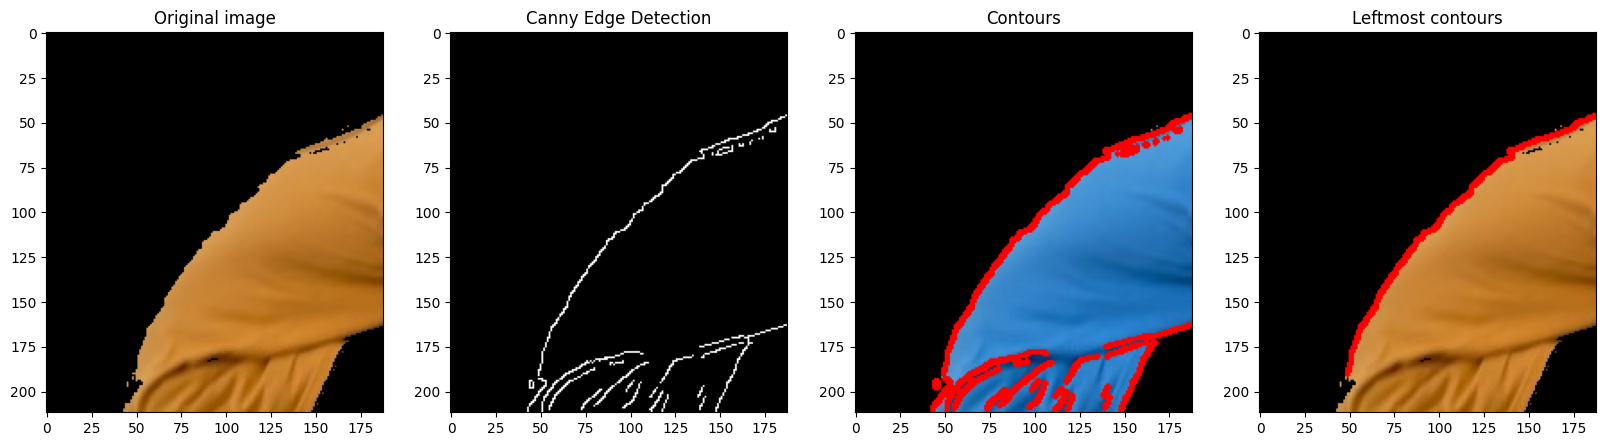

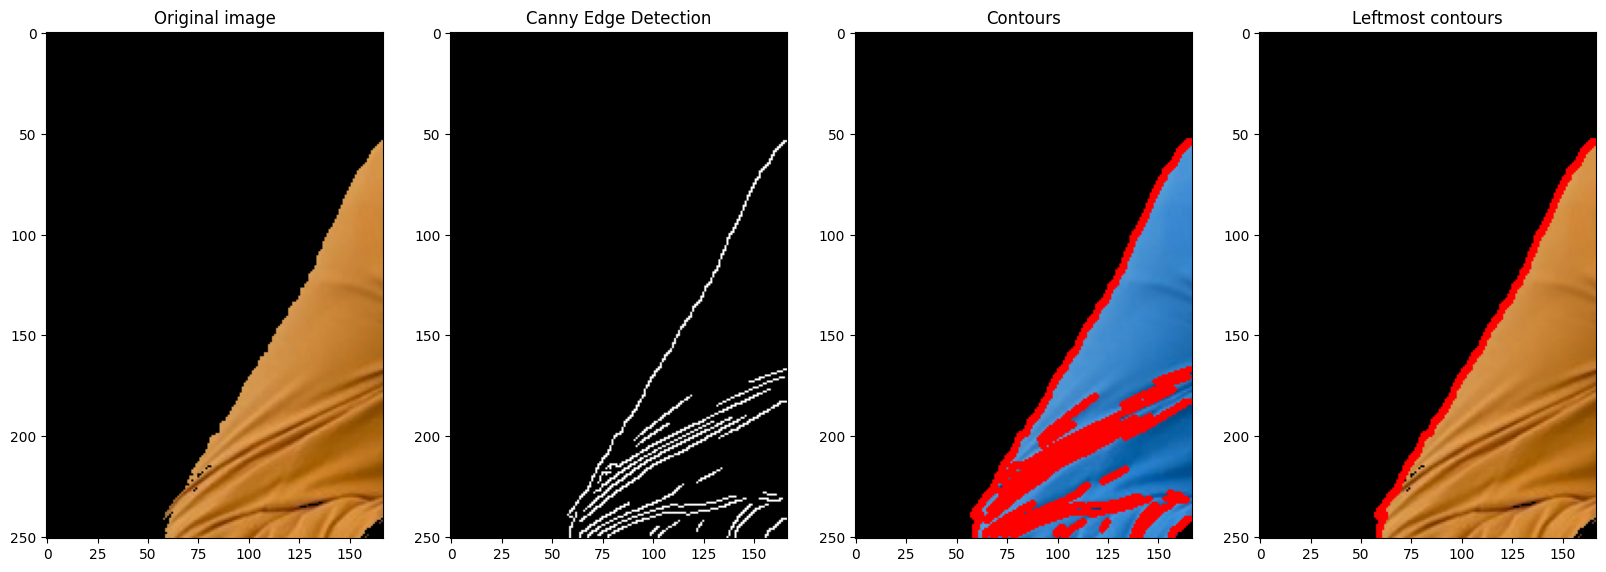

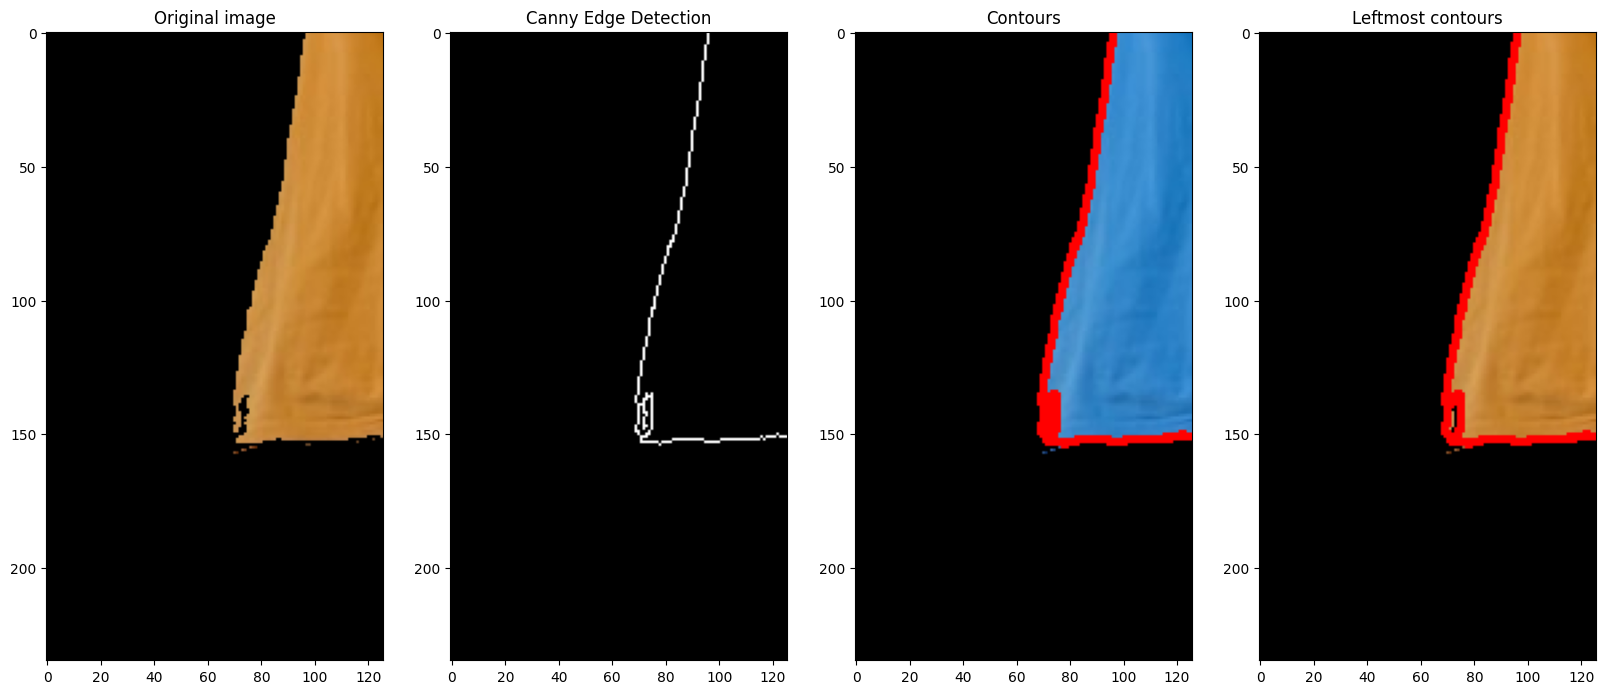

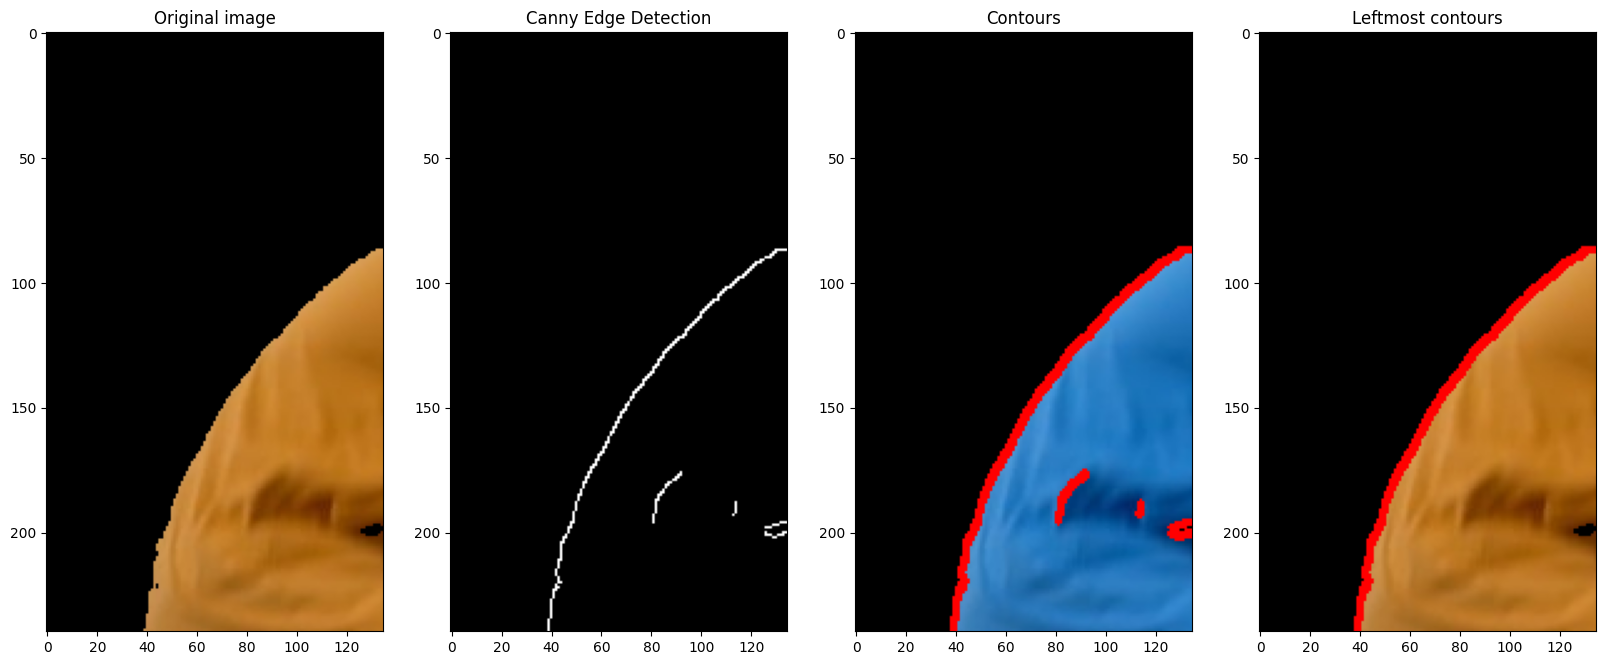

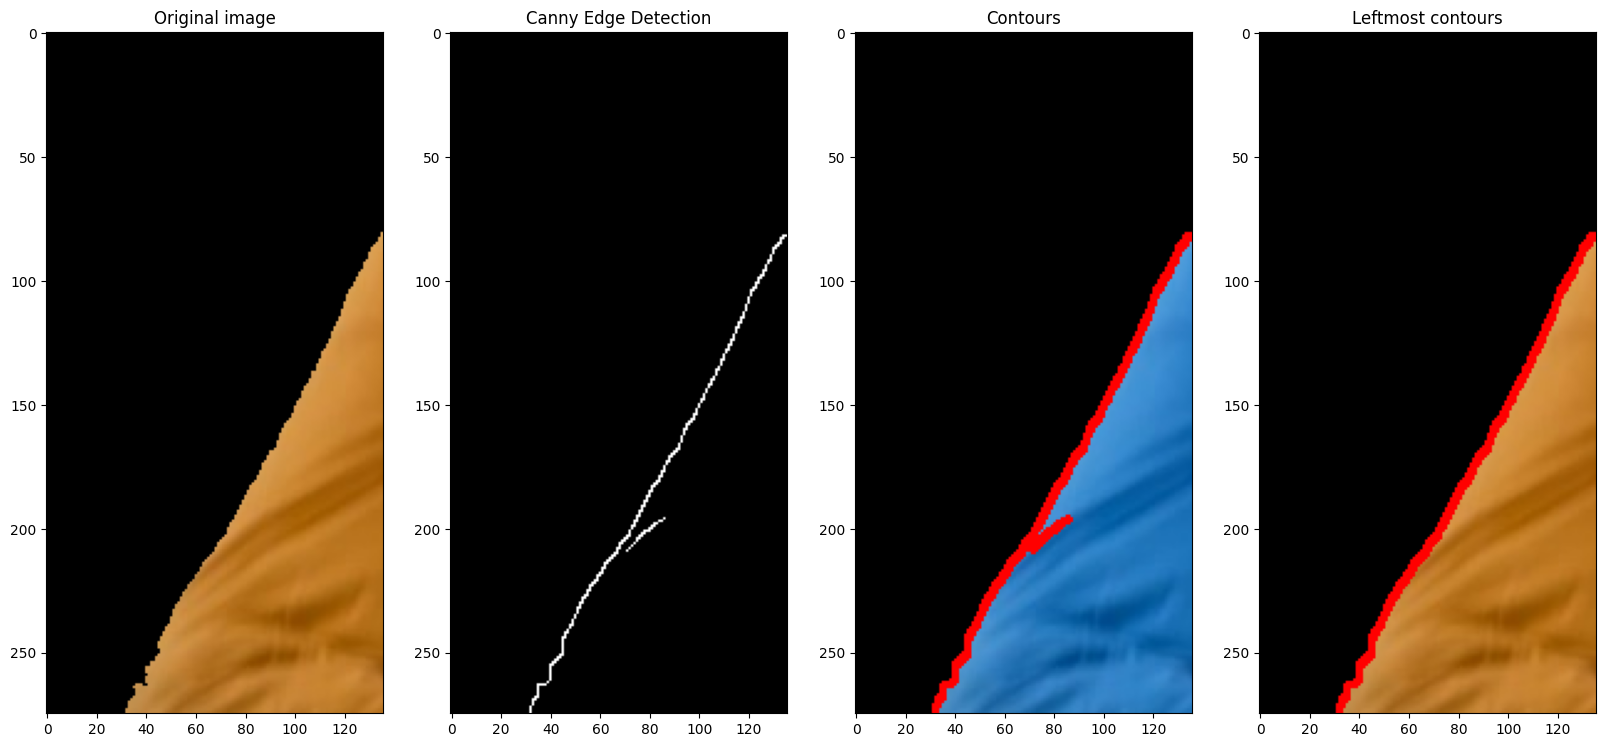

In [69]:
spine_contours = []

for img in img_filtered:
    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    img_blur = cv.GaussianBlur(img_gray, (5, 5), 0)

    # Apply Canny Edge Detection
    img_canny = cv.Canny(img_blur, 100, 110)

    # Konturen extrahieren
    contours, hierarchy = cv.findContours(img_canny, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Bild kopieren, um das Originalbild nicht zu verändern
    img_contours = img.copy()

    # Zeichnen Sie die Kontur ganz links auf das Ergebnisbild
    cv.drawContours(img_contours, contours, -1, (255, 0, 0), 2)

    # Kontur ganz links identifizieren

    # Sortiere die Konturen nach x- und y-Koordinate
    contours = sorted(contours, key=lambda x: cv.boundingRect(x)[0] + cv.boundingRect(x)[1])

    # Wähle die Kontur ganz links
    leftmost_contour = contours[0]

    # Bild kopieren, um das Originalbild nicht zu verändern
    img_left_contours = img.copy()

    # Zeichnen Sie die Kontur ganz links auf das Ergebnisbild
    cv.drawContours(img_left_contours, [leftmost_contour], -1, (0, 0, 255), 2)

    # add leftmost contour to result list
    spine_contours.append(leftmost_contour)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.subplot(1, 4, 2)
    plt.imshow(img_canny, cmap='gray')
    plt.title('Canny Edge Detection')
    plt.subplot(1, 4, 3)
    plt.imshow(img_contours, cmap='gray')
    plt.title('Contours')
    plt.subplot(1, 4, 4)
    plt.imshow(cv.cvtColor(img_left_contours, cv.COLOR_BGR2RGB))
    plt.title('Leftmost contours')
    plt.show()

In [70]:
len(spine_contours)

5

In [71]:
(spine_contours[0][0][0])

array([187,  46], dtype=int32)

# Curve / Polynom Fitting
Polynom Fitting 2. Grade for the leftmost detected contour.

    $a * x**2 + b * x + c$
    
If parameter a exceeds a specified value, the spine is considered curved. otherwise it is considered straight

Curve found
left_fit: 0.006371860279354493x^2 + -2.4411608159291833x + 284.2926863747976


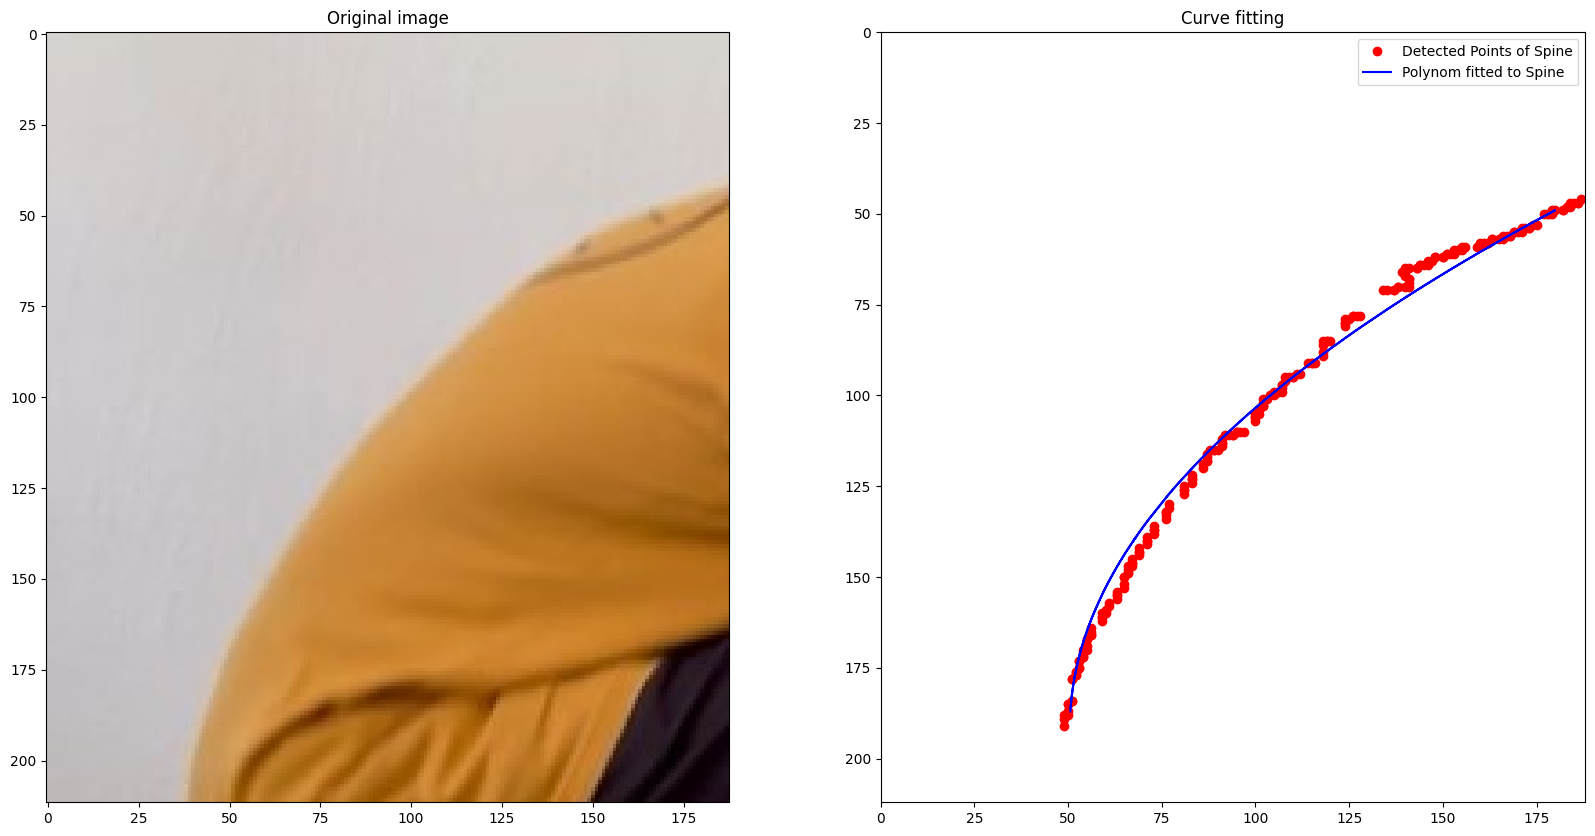

No curve found


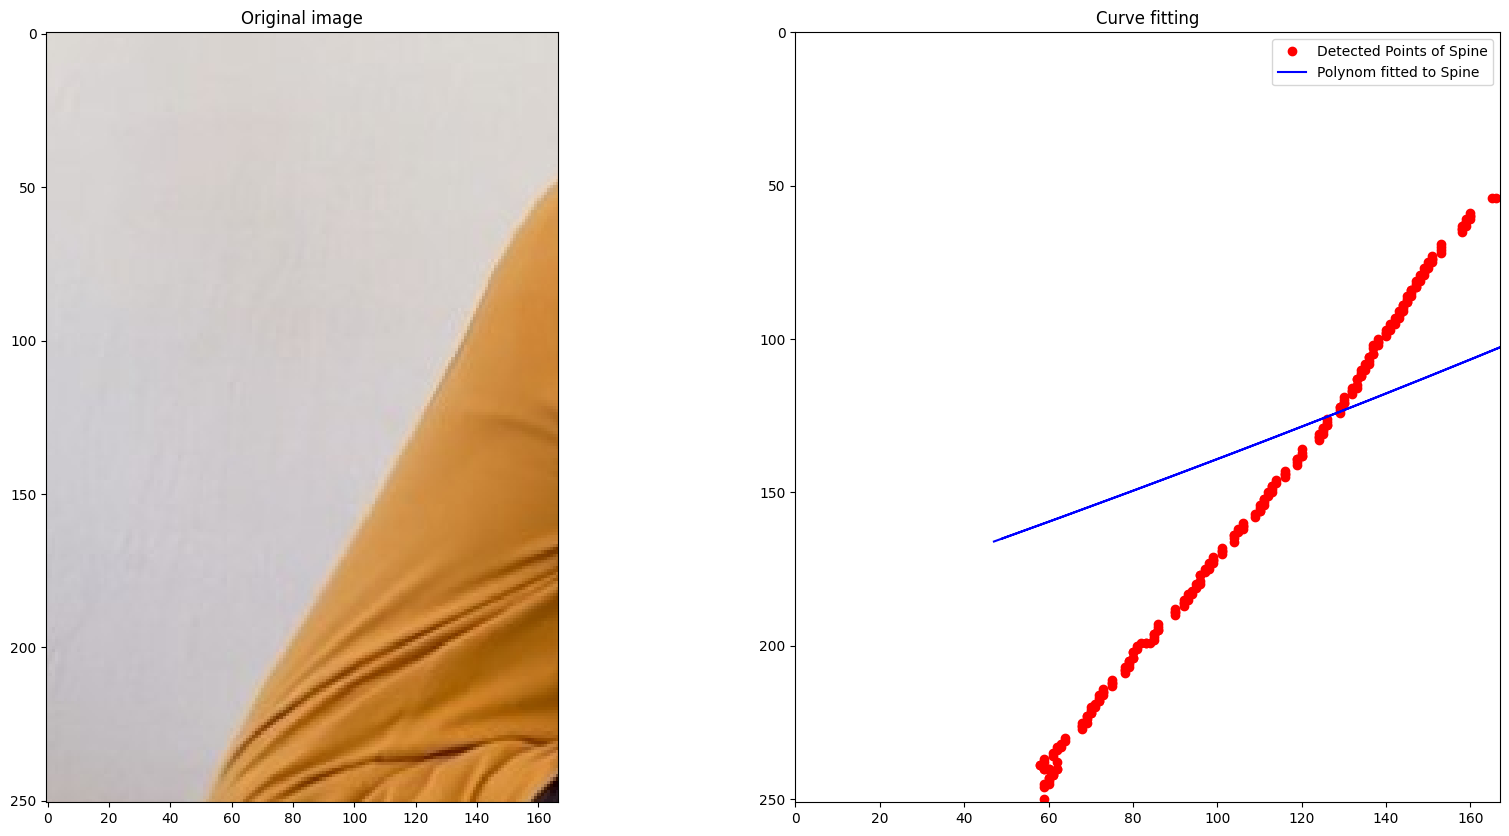

Curve found
left_fit: 0.14455521298331858x^2 + -27.337405134620976x + 1350.8906831708814


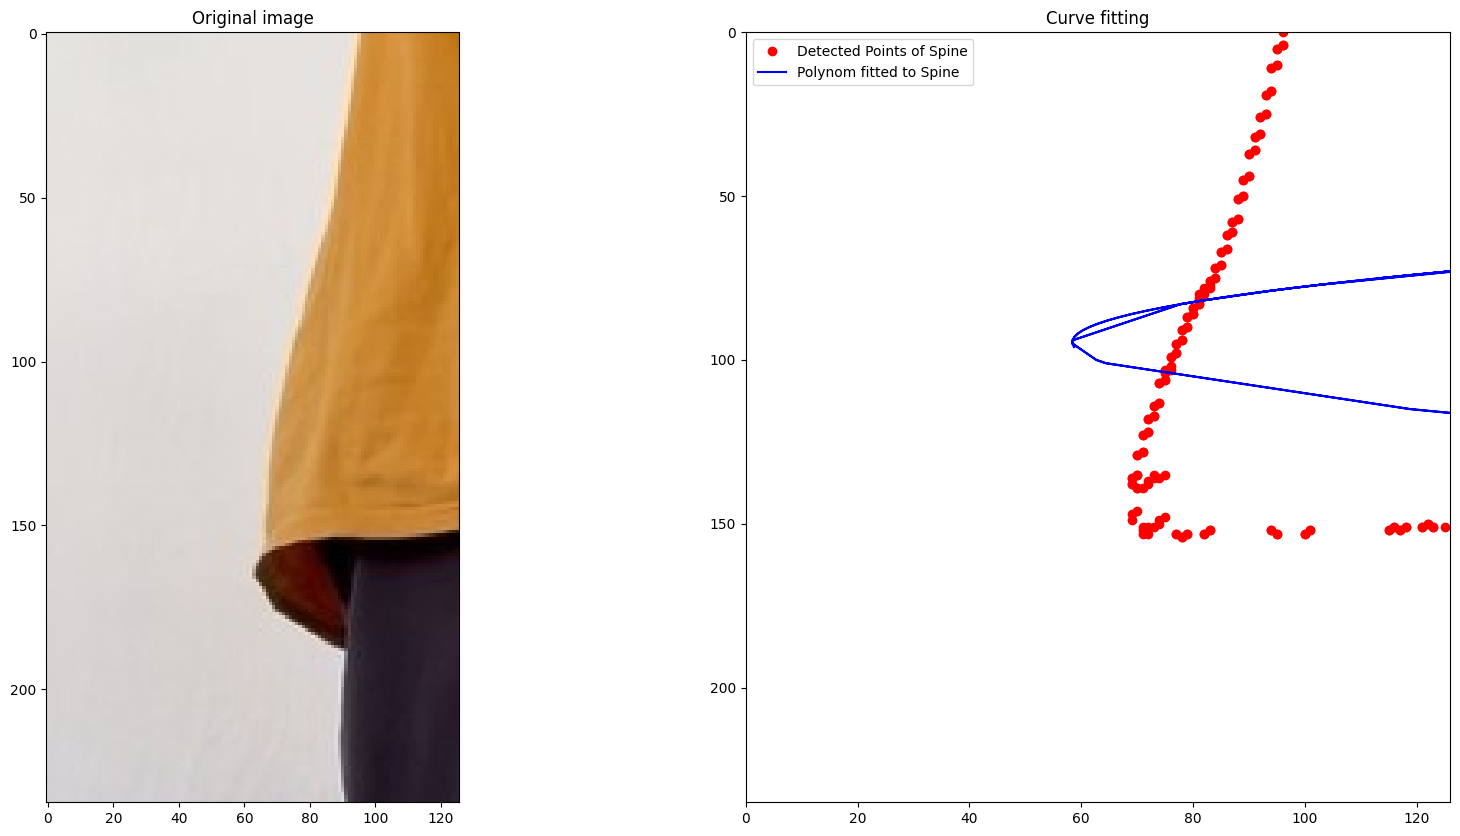

Curve found
left_fit: 0.015537090687606527x^2 + -4.052992549650811x + 358.0187998925797


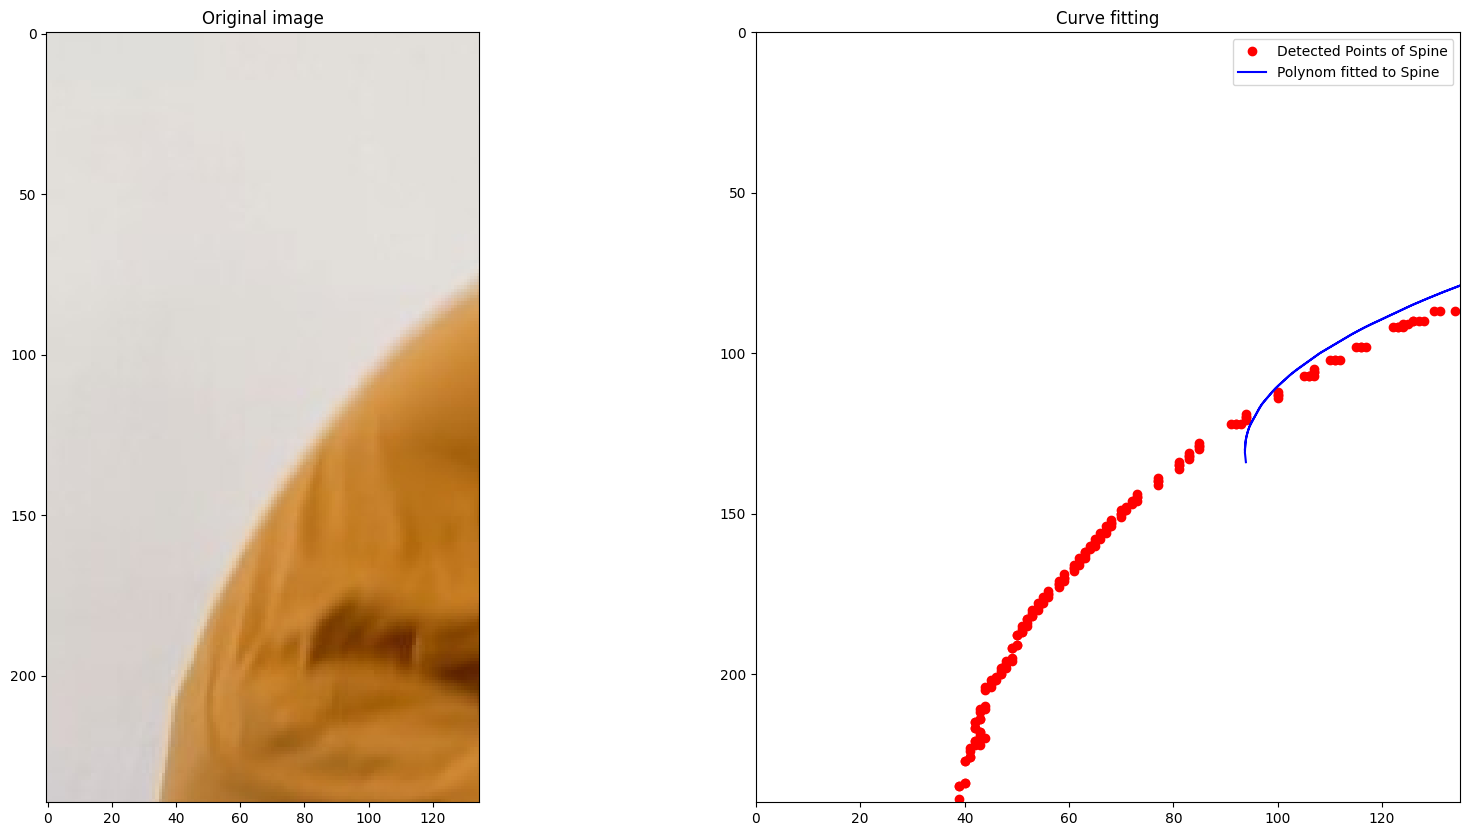

No curve found


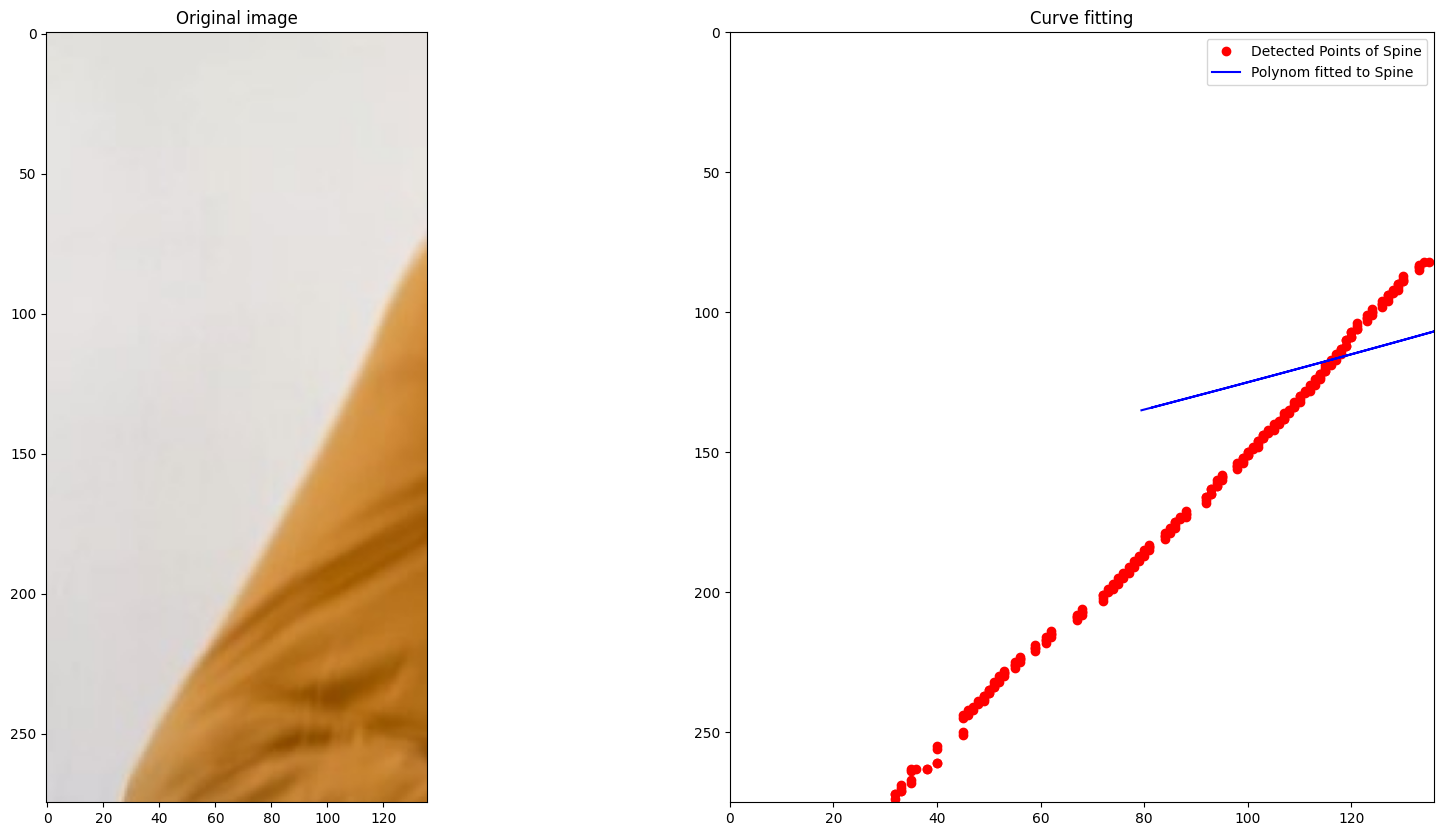

In [72]:
def generate_curve_function(params):
    return lambda x: params[0] * x ** 2 + params[1] * x + params[2]


curves = []

kernel_ver = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]], 'uint8')

for img, sp in zip(cropped_images, spine_contours):
    # extract x and y values of contour
    x = sp[:, 0, 0]
    y = sp[:, 0, 1]

    fit = np.polyfit(x, y, 2)
    # cuver found?
    if fit[0] > 0.0001:
        print("Curve found")
        # parameters for curve fitting are stored in left_fit and right_fit as a list 
        # fit[0] * x**2 + fit[1] * x + fit[2]
        print("left_fit: " + str(fit[0]) + "x^2 + " + str(fit[1]) + "x + " + str(fit[2]))
    else:
        print("No curve found")

    # show curve fitting
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    # show img in rgb
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.subplot(1, 2, 2)
    plt.plot(x, y, 'o', color='red')
    plt.plot(np.polyval(fit, x), x, '-', color='blue')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.legend(['Detected Points of Spine', 'Polynom fitted to Spine'])
    plt.title("Curve fitting")
    plt.show()